## 날씨와 자전거 대여 관계 분석

#### 데이터셋 설명
- 서울시 공공자전거 이용현황(https://data.seoul.go.kr/dataList/OA-14994/F/1/datasetView.do)
    - 서울시에서 운영하는 공공자전거(따릉이)에 대한 기간별, 대여소별 이용(대여, 반납)현황 데이터입니다.
- 날씨데이터(https://www.data.go.kr/data/15059093/openapi.do#/tab_layer_detail_function)
    - 종관기상관측 장비로 관측한 일 기상자료를 조회하는 API 서비스입니다.

## Importing Libraries

In [1]:
import requests
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [30]:
plt.rc('font',family='Malgun Gothic')

## Loading the Dataset

In [3]:
# 서울시 자전거 이용현황

seoul_bicycle = pd.read_csv('./raw_data/서울특별시 공공자전거 일별 대여건수_23.1-6.csv', encoding='cp949')
# 대여일시, 대여건수만 남기고 drop
seoul_bicycle = seoul_bicycle[['대여일시', '대여건수']]
# column rename
seoul_bicycle = seoul_bicycle.rename(columns={
    '대여일시' : '일시',
    '대여건수' : '대여건수'
})
seoul_bicycle.head()
seoul_bicycle.tail()

,일시,대여건수
0,2023-01-01,"38,037"
1,2023-01-02,"56,609"
2,2023-01-03,"61,252"
3,2023-01-04,"67,721"
4,2023-01-05,"68,711"


,일시,대여건수
175,2023-06-25,"133,566"
176,2023-06-27,"179,792"
177,2023-06-28,"185,929"
178,2023-06-29,"35,326"
179,2023-06-30,"155,252"


In [4]:
# 기상청_지상(종관, ASOS) 일자료 조회서비스

url = 'http://apis.data.go.kr/1360000/AsosDalyInfoService/getWthrDataList'

# stnIds : 108 -> 서울 수도권기상청
# numOfRows : 900 -> 2023-01-01~2023-06-30
params ={'serviceKey' : 'pYC4QZ59nwGWzNKv4cnGDzcFQ14IFDWStxSl/NOXW7XDMRiO1o4rx3hxdqfbXqWZQBe7Qz4zTF7KxPSy/JiNKw==', 
         'pageNo' : '1', 
         'numOfRows' : '900', 
         'dataType' : 'JSON', 
         'dataCd' : 'ASOS', 
         'dateCd' : 'DAY', 
         'startDt' : '20230101', 
         'endDt' : '20230630', 
         'stnIds' : '108' }

response = requests.get(url, params=params)

data = json.loads(response.content)

# 기상청 데이터에서 필요한 데이터만 수집
# tm -> 일시
# minTa -> 최저 기온
# maxTa -> 최고 기온
# avgRhm -> 평균 상대습도
# avgWs -> 평균 풍속
# avgTa -> 평균 기온
# minTaHrmt -> 최저 기온 시각
# maxTaHrmt -> 최대 기온 시각

# 빈 데이터프레임 생성
columns = ['tm', 'minTa', 'maxTa', 'avgRhm', 'avgWs', 'avgTa', 'minTaHrmt', 'maxTaHrmt']
seoul_weather = pd.DataFrame(columns=columns)

# 각 데이터를 데이터프레임에 추가
for item in data['response']['body']['items']['item']:
    seoul_weather = seoul_weather.append(item, ignore_index=True)

seoul_weather.head()
seoul_weather.tail()

,tm,minTa,maxTa,avgRhm,avgWs,avgTa,minTaHrmt,maxTaHrmt,avgCm10Te,avgCm20Te,...,stnId,stnNm,sumDpthFhsc,sumFogDur,sumGsr,sumLrgEv,sumRn,sumRnDur,sumSmlEv,sumSsHr
0,2023-01-01,-4.3,3.8,54.5,2.7,-0.2,2350,1343,-0.5,-0.5,...,108,서울,,,10.81,1.6,,,2.3,9.0
1,2023-01-02,-7.4,-0.4,45.9,2.5,-4.5,0804,1525,-1.0,-0.5,...,108,서울,,,11.63,1.3,,,1.9,9.1
2,2023-01-03,-9.0,0.6,49.0,1.8,-5.0,0551,1555,-1.5,-0.8,...,108,서울,,,11.77,1.3,,,1.9,9.1
3,2023-01-04,-5.7,3.3,51.4,1.9,-1.8,0229,1510,-1.2,-0.8,...,108,서울,,,10.89,1.5,,,2.1,8.7
4,2023-01-05,-5.6,3.6,58.1,1.6,-1.6,0749,1536,-1.1,-0.8,...,108,서울,,,6.09,0.9,,,1.2,4.7


,tm,minTa,maxTa,avgRhm,avgWs,avgTa,minTaHrmt,maxTaHrmt,avgCm10Te,avgCm20Te,...,stnId,stnNm,sumDpthFhsc,sumFogDur,sumGsr,sumLrgEv,sumRn,sumRnDur,sumSmlEv,sumSsHr
176,2023-06-26,22.3,27.5,88.6,2.9,24.2,0606,0001,25.4,24.8,...,108,서울,,,3.39,1.2,30.3,13.25,1.7,0.0
177,2023-06-27,21.4,29.1,73.1,3.2,25.3,0525,1657,25.5,24.3,...,108,서울,,,20.95,4.1,2.5,2.5,5.9,6.8
178,2023-06-28,24.2,30.1,77.4,2.5,26.5,0447,1453,26.6,25.2,...,108,서울,,,18.56,3.6,0.0,0.5,5.1,3.8
179,2023-06-29,23.2,25.9,95.4,2.3,24.2,2343,0007,25.7,25.0,...,108,서울,,0.5,2.31,0.6,63.8,17.83,0.9,0.0
180,2023-06-30,23.2,29.1,89.8,1.8,25.3,0001,1603,25.4,24.4,...,108,서울,,2.2,10.02,2.3,1.0,11.92,3.3,1.4


In [5]:
seoul_weather.columns

Index(['tm', 'minTa', 'maxTa', 'avgRhm', 'avgWs', 'avgTa', 'minTaHrmt',
       'maxTaHrmt', 'avgCm10Te', 'avgCm20Te', 'avgCm30Te', 'avgCm5Te',
       'avgLmac', 'avgM05Te', 'avgM10Te', 'avgM15Te', 'avgM30Te', 'avgM50Te',
       'avgPa', 'avgPs', 'avgPv', 'avgTca', 'avgTd', 'avgTs', 'ddMefs',
       'ddMefsHrmt', 'ddMes', 'ddMesHrmt', 'hr1MaxIcsr', 'hr1MaxIcsrHrmt',
       'hr1MaxRn', 'hr1MaxRnHrmt', 'hr24SumRws', 'iscs', 'maxInsWs',
       'maxInsWsHrmt', 'maxInsWsWd', 'maxPs', 'maxPsHrmt', 'maxWd', 'maxWs',
       'maxWsHrmt', 'maxWsWd', 'mi10MaxRn', 'mi10MaxRnHrmt', 'minPs',
       'minPsHrmt', 'minRhm', 'minRhmHrmt', 'minTg', 'n99Rn', 'ssDur', 'stnId',
       'stnNm', 'sumDpthFhsc', 'sumFogDur', 'sumGsr', 'sumLrgEv', 'sumRn',
       'sumRnDur', 'sumSmlEv', 'sumSsHr'],
      dtype='object')

In [6]:
# 필요한 column으로 재구성
seoul_weather = seoul_weather[['tm', 'minTa', 'maxTa', 'avgRhm', 'avgWs', 'avgTa', 'minTaHrmt', 'maxTaHrmt']]

# columns rename
seoul_weather = seoul_weather.rename(columns={
    'tm' : '일시',
    'minTa' : '최저 기온',
    'maxTa' : '최고 기온',
    'avgRhm' : '평균 상대습도',
    'avgWs' : '평균 풍속',
    'avgTa' : '평균 기온',
    'minTaHrmt' : '최저 기온 시각',
    'maxTaHrmt' : '최대 기온 시각'
})

seoul_weather.head()
seoul_weather.tail()

,일시,최저 기온,최고 기온,평균 상대습도,평균 풍속,평균 기온,최저 기온 시각,최대 기온 시각
0,2023-01-01,-4.3,3.8,54.5,2.7,-0.2,2350,1343
1,2023-01-02,-7.4,-0.4,45.9,2.5,-4.5,0804,1525
2,2023-01-03,-9.0,0.6,49.0,1.8,-5.0,0551,1555
3,2023-01-04,-5.7,3.3,51.4,1.9,-1.8,0229,1510
4,2023-01-05,-5.6,3.6,58.1,1.6,-1.6,0749,1536


,일시,최저 기온,최고 기온,평균 상대습도,평균 풍속,평균 기온,최저 기온 시각,최대 기온 시각
176,2023-06-26,22.3,27.5,88.6,2.9,24.2,0606,0001
177,2023-06-27,21.4,29.1,73.1,3.2,25.3,0525,1657
178,2023-06-28,24.2,30.1,77.4,2.5,26.5,0447,1453
179,2023-06-29,23.2,25.9,95.4,2.3,24.2,2343,0007
180,2023-06-30,23.2,29.1,89.8,1.8,25.3,0001,1603


In [7]:
# 날짜 기준으로 데이터 병합

df = pd.merge(seoul_bicycle, seoul_weather, on='일시', how='inner')

df.head()
df.tail()

,일시,대여건수,최저 기온,최고 기온,평균 상대습도,평균 풍속,평균 기온,최저 기온 시각,최대 기온 시각
0,2023-01-01,"38,037",-4.3,3.8,54.5,2.7,-0.2,2350,1343
1,2023-01-02,"56,609",-7.4,-0.4,45.9,2.5,-4.5,0804,1525
2,2023-01-03,"61,252",-9.0,0.6,49.0,1.8,-5.0,0551,1555
3,2023-01-04,"67,721",-5.7,3.3,51.4,1.9,-1.8,0229,1510
4,2023-01-05,"68,711",-5.6,3.6,58.1,1.6,-1.6,0749,1536


,일시,대여건수,최저 기온,최고 기온,평균 상대습도,평균 풍속,평균 기온,최저 기온 시각,최대 기온 시각
175,2023-06-25,"133,566",22.8,33.1,64.9,2.1,28.2,0545,1529
176,2023-06-27,"179,792",21.4,29.1,73.1,3.2,25.3,0525,1657
177,2023-06-28,"185,929",24.2,30.1,77.4,2.5,26.5,0447,1453
178,2023-06-29,"35,326",23.2,25.9,95.4,2.3,24.2,2343,0007
179,2023-06-30,"155,252",23.2,29.1,89.8,1.8,25.3,0001,1603


## Preprocessing

In [8]:
# 최저 기온 시각, 최대 기온 시각 ->pd.DateTime 으로 변환
# 대여건수 가장 많은 일시, 가장 적은 일시
# 최저 기온 최고 기온 평균 상대습도 평균 풍속 평균 기온에 따른 대여건수 상관관계 분석
# 시각 별 대여건수 가장 많은 평균 시각 구하기

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 179
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   일시        180 non-null    object
 1   대여건수      180 non-null    object
 2   최저 기온     180 non-null    object
 3   최고 기온     180 non-null    object
 4   평균 상대습도   180 non-null    object
 5   평균 풍속     180 non-null    object
 6   평균 기온     180 non-null    object
 7   최저 기온 시각  180 non-null    object
 8   최대 기온 시각  180 non-null    object
dtypes: object(9)
memory usage: 14.1+ KB


In [10]:
df['최저 기온 시각'].unique()

df['최대 기온 시각'].unique()

array(['2350', '0804', '0551', '0229', '0749', '0816', '2354', '0800',
       '2400', '0724', '0802', '0645', '0225', '2328', '2338', '0849',
       '0311', '0815', '0601', '2353', '0713', '0117', '0144', '0502',
       '2333', '0813', '0607', '0449', '0402', '0719', '0118', '0535',
       '0726', '0716', '0727', '0509', '2356', '0703', '0624', '2351',
       '0730', '0706', '0543', '0006', '2341', '2357', '0759', '0712',
       '0629', '0729', '0646', '2355', '0736', '0708', '0702', '0701',
       '0559', '2316', '0456', '0659', '0651', '0331', '0652', '0707',
       '0704', '0532', '2358', '0633', '0635', '0615', '0549', '0644',
       '0655', '0617', '0636', '2352', '2218', '2339', '0518', '0526',
       '0611', '0030', '2359', '0529', '0541', '0803', '0552', '2256',
       '0621', '0557', '2349', '2244', '0610', '0613', '2144', '0430',
       '0558', '0523', '0626', '0547', '0838', '2327', '0550', '0545',
       '0608', '0520', '0515', '0442', '0531', '2313', '0603', '0412',
      

array(['1343', '1525', '1555', '1510', '1536', '1414', '1336', '1522',
       '1238', '1530', '1410', '1600', '1628', '0001', '1432', '1402',
       '1452', '1419', '0222', '1533', '1345', '1620', '1559', '1548',
       '1554', '1426', '1515', '1606', '1540', '1528', '1338', '1458',
       '1546', '1505', '1537', '1610', '1417', '1351', '1219', '1521',
       '1558', '1459', '1542', '1529', '1457', '1618', '1531', '1501',
       '1527', '1534', '1553', '1541', '1445', '1513', '1415', '1455',
       '1443', '1237', '1428', '1444', '1215', '1349', '1543', '1532',
       '1539', '1627', '1425', '1517', '1511', '1507', '1503', '1508',
       '1604', '1608', '1301', '1312', '1404', '1431', '0928', '1520',
       '1512', '1621', '1551', '1726', '1506', '1347', '1007', '1526',
       '0755', '1623', '1552', '1509', '1435', '1635', '1340', '1500',
       '1423', '1400', '1436', '1310', '1326', '1409', '1200', '1622',
       '1650', '1329', '1403', '0851', '1315', '1646', '1454', '1625',
      

In [11]:
# '일시' 컬럼을 datetime 형식으로 변환
df['일시'] = pd.to_datetime(df['일시'])

# '최저 기온 시각'과 '최대 기온 시각' 컬럼을 '시:분' 형태의 문자열로 변환
df['최저 기온 시각'] = df['최저 기온 시각'].str.zfill(4).apply(lambda x: f"{x[:2]}:{x[2:]}")
df['최대 기온 시각'] = df['최대 기온 시각'].str.zfill(4).apply(lambda x: f"{x[:2]}:{x[2:]}")

In [12]:
# 변환 확인
df.dtypes

일시          datetime64[ns]
대여건수                object
최저 기온               object
최고 기온               object
평균 상대습도             object
평균 풍속               object
평균 기온               object
최저 기온 시각            object
최대 기온 시각            object
dtype: object

,일시,대여건수,최저 기온,최고 기온,평균 상대습도,평균 풍속,평균 기온,최저 기온 시각,최대 기온 시각
0,2023-01-01,"38,037",-4.3,3.8,54.5,2.7,-0.2,23:50,13:43
1,2023-01-02,"56,609",-7.4,-0.4,45.9,2.5,-4.5,08:04,15:25
2,2023-01-03,"61,252",-9.0,0.6,49.0,1.8,-5.0,05:51,15:55
3,2023-01-04,"67,721",-5.7,3.3,51.4,1.9,-1.8,02:29,15:10
4,2023-01-05,"68,711",-5.6,3.6,58.1,1.6,-1.6,07:49,15:36
...,...,...,...,...,...,...,...,...,...
175,2023-06-25,"133,566",22.8,33.1,64.9,2.1,28.2,05:45,15:29
176,2023-06-27,"179,792",21.4,29.1,73.1,3.2,25.3,05:25,16:57
177,2023-06-28,"185,929",24.2,30.1,77.4,2.5,26.5,04:47,14:53
178,2023-06-29,"35,326",23.2,25.9,95.4,2.3,24.2,23:43,00:07


## Visualization

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, '1월부터 6월까지 대여건수가 가장 많은 일자')

Text(0.5, 0, '일시')

Text(0, 0.5, '대여건수')

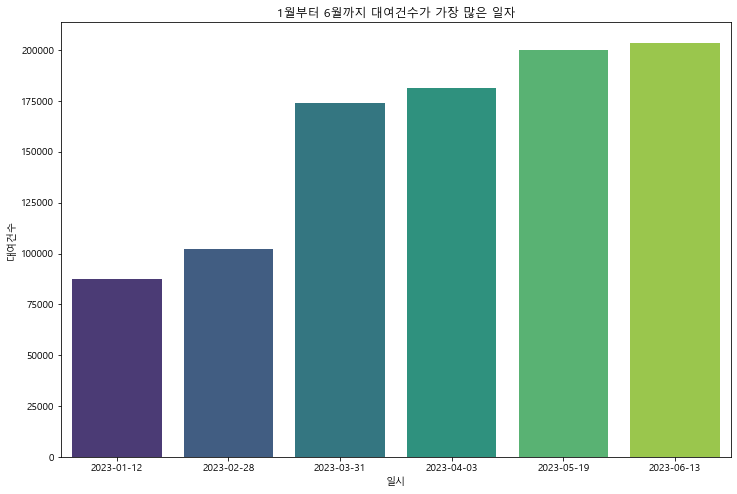

In [32]:
# 1월부터 6월까지 가장 많은 대여건수 일자만 시각화

rental_df = df[['일시', '대여건수']].copy()

# '일시' 열을 날짜와 시간으로 분리
rental_df['날짜'] = pd.to_datetime(rental_df['일시']).dt.date
rental_df['시간'] = pd.to_datetime(rental_df['일시']).dt.time

# '월' 정보를 추출
rental_df['월'] = pd.to_datetime(rental_df['날짜']).dt.month

# 1월부터 6월까지의 데이터 필터링
filtered_df = rental_df[rental_df['월'].between(1, 6)]

# 각 월별로 대여건수가 가장 많은 일자 찾기
max_rental_dates = filtered_df.groupby('월')['대여건수'].idxmax()

# 찾은 일자를 이용하여 데이터 추출
max_rental_data = rental_df.loc[max_rental_dates]

#일시 string으로 형변환
max_rental_data['일시_str'] = max_rental_data['일시'].astype(str)

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x='일시_str', y='대여건수', data=max_rental_data, palette='viridis')
plt.title('1월부터 6월까지 대여건수가 가장 많은 일자')
plt.xlabel('일시')
plt.ylabel('대여건수')
plt.show()


## Analysis

### 대여건수가 가장 많은 일시와 가장 적은 일시는 ?

In [ ]:
# '대여건수' 열을 숫자로 변환
df['대여건수'] = df['대여건수'].str.replace(',', '').astype(int)

# 대여건수가 가장 많은 일시와 대여건수
max_rental_date = df.loc[df['대여건수'].idxmax(), ['일시', '대여건수']]
max_rental_date_str = max_rental_date['일시'].strftime('%Y-%m-%d')
max_rental_count = max_rental_date['대여건수']

# 대여건수가 가장 적은 일시와 대여건수
min_rental_date = df.loc[df['대여건수'].idxmin(), ['일시', '대여건수']]
min_rental_date_str = min_rental_date['일시'].strftime('%Y-%m-%d')
min_rental_count = min_rental_date['대여건수']

print("가장 많은 대여건수의 일시:", max_rental_date_str, "대여건수:", max_rental_count)
print("가장 적은 대여건수의 일시:", min_rental_date_str, "대여건수:", min_rental_count)

### 최저 기온, 최고 기온, 평균 상대습도, 평균 풍속, 평균 기온에 따른 대여건수 상관관계 분석

In [ ]:
# 필요한 컬럼만 추출
correlation_data = df[['대여건수', '최저 기온', '최고 기온', '평균 상대습도', '평균 풍속', '평균 기온']]

# 상관관계 계산
correlation_matrix = correlation_data.corr()

print("대여건수와 각 변수의 상관관계:")
print(correlation_matrix['대여건수'])

# 시각화

### 시각 별 대여건수가 가장 많은 평균 시각 구하기

In [ ]:
df['최저 기온 시각'] = df['최저 기온 시각'].replace('24:00', '00:00')

In [ ]:
# 시각 데이터를 시:분 형식으로 변환
df['최저 기온 시각'] = pd.to_datetime(df['최저 기온 시각'], format='%H:%M').dt.time
df['최대 기온 시각'] = pd.to_datetime(df['최대 기온 시각'], format='%H:%M').dt.time

# 새로운 컬럼 추가: 대여건수의 평균
df['대여건수 평균'] = df['대여건수'].mean()

# 대여건수가 평균 이상인 데이터만 추출
peak_rental_times = df[df['대여건수'] > df['대여건수 평균']]

# 대여건수가 가장 많은 평균 시각
peak_rental_time = peak_rental_times['최저 기온 시각'].mode().iloc[0]

print("대여건수가 가장 많은 평균 시각:", peak_rental_time)